# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

## https://huggingface.co/kunwwarsaaim/distill-bert-fake-news-detection

In [ ]:
!pip install transformers

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)

Batch size: 256


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/news_dataset')

Mounted at /content/drive


In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv') 

In [ ]:
true_news['class_'] = [0]*len(true_news)
fake_news['class_'] = [1]*len(fake_news)
dataset = pd.concat([true_news,fake_news]).reset_index(drop=True)
dataset = shuffle(dataset)

dataset['data'] = dataset['title']+ ' ' + dataset['text']
dataset.drop(['title','text','subject','date'],axis=1,inplace=True)
dataset.drop_duplicates(inplace=True)

In [ ]:
dataset.keys()

Index(['class_', 'data'], dtype='object')

In [ ]:
data = list(dataset.data)
label = dataset.class_

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Tokenizer
inputs = tokenizer(data, padding=True, truncation=True, return_tensors='tf') #Tokenized text

In [ ]:
len(inputs['input_ids']) == len(label)

True

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), label)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.2*len(label))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
with tpu_strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
  model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
        )
 
history=model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
122/122 [==============================] - 106s 457ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.0124 - val_sparse_categorical_accuracy: 0.9993
Epoch 2/5
122/122 [==============================] - 50s 414ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0042 - val_sparse_categorical_accuracy: 0.9997
Epoch 3/5
122/122 [==============================] - 50s 414ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0030 - val_sparse_categorical_accuracy: 0.9996
Epoch 4/5
122/122 [==============================] - 51s 414ms/step - loss: 0.0019 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0014 - val_sparse_categorical_accuracy: 0.9999
Epoch 5/5
122/122 [==============================] - 51s 415ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0036 - val_sparse_categorical_accuracy: 0.9993


In [ ]:
model.save_weights('./distill_bert_fake_news_saved_weights_epoch_5_0-8.h5')

In [ ]:
model.evaluate(val_ds)

30/30 [==============================] - 5s 121ms/step - loss: 0.0036 - sparse_categorical_accuracy: 0.9993


[0.0036058793775737286, 0.9993489980697632]

In [ ]:
output = model.predict(val_ds)

In [ ]:
val_labels = list(val_ds.as_numpy_iterator())

In [ ]:
val_true = []
for i in range(len(val_labels)):
  val_true.append(val_labels[i][1])

In [ ]:
val_text = []
for i in range(len(val_labels)):
  val_text.append(val_labels[i][0]['input_ids'])

In [ ]:
import numpy as np
val_true_ = np.concatenate(val_true)

In [ ]:
val_text_ = np.concatenate(val_text)

In [ ]:
from scipy.special import softmax

In [ ]:
output_softmax = softmax(output.logits,axis=1)

In [ ]:
output_values = np.argmax(output_softmax,axis=1)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_true_, output_softmax[:,1])
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(val_true_, output_softmax[:,1])
print('AUC: %.3f' % auc)

AUC: 1.000


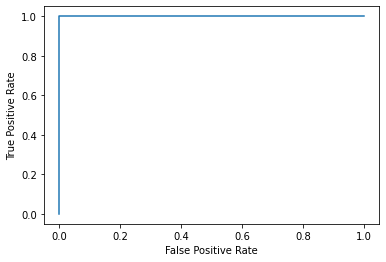

In [ ]:
import matplotlib.pyplot as plt

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
bool_ = output_values == val_true_

In [ ]:
bool_ = list(bool_)

In [ ]:
indices = [i for i, x in enumerate(bool_) if x == False]

In [ ]:
indices = [1339, 2615, 6600, 7026] #wrong prediction

In [ ]:
for i in indices: # 0 -> True News 1-> False News
  print('Sample ',i)
  print('Predicted Value: ',np.argmax(softmax(model.predict(val_text_[i,:].reshape(1,512)).logits,axis=1),axis=1),' True Value: ',val_true_[i])


Sample  1339
Predicted Value:  [0]  True Value:  1
Sample  2615
Predicted Value:  [0]  True Value:  1
Sample  6600
Predicted Value:  [0]  True Value:  1
Sample  7026
Predicted Value:  [0]  True Value:  1


In [ ]:
print('Wrong Prediction')
for i in indices:
  print(tokenizer.decode(val_text_[i]))

Wrong Prediction
[CLS] trump tells state department to make cut more than 50 % of funding to u. n. president trump s administration has told the state department to cut more than 50 percent of u. s. funding to united nations programs, foreign policy reported. the push for the drastic reductions comes as the white house is scheduled to release its 2018 topline budget proposal thursday, which is expected to include a 37 percent cut to the state department and u. s. agency for international development budgets. it s not clear if trump s budget plan, from the office of management and budget, would reflect the full extent of trump s proposed cuts to the u. n. richard gowan, a u. n. expert at the european council on foreign relations, said the alterations would spark chaos if true. [ it would ] leave a gaping hole that other big donors would struggle to fill, he told fp, pointing to how the u. s. provided $ 1. 5 billion of the u. n. refugee agency s $ 4 billion budget last year. via : the hi

#The model classifies only 4 data samples predicted as true news though they are fake news. It is performing well on the test set though it is not very large (20% of the data). Model hyperparameter tuning could be done to get more accurate results on larger dataset. Particularly automated hyperparameter tuning using libraries like optuna.

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?